In [29]:
import itertools
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils 
from torch.autograd import Variable

from torchvision import transforms

import numpy as np
import pandas as pd

%matplotlib inline

In [4]:
trn = pd.read_csv("./trn.tsv", sep='\t')
val = pd.read_csv("./val.tsv", sep='\t')

trn.head()

X_features = ["feature_1", "feature_2", "feature_3", "feature_4", "feature_5", "feature_6", "feature_7", "feature_8"]
y_feature = ["y"]

trn_X_pd, trn_y_pd = trn[X_features], trn[y_feature]
val_X_pd, val_y_pd = val[X_features], val[y_feature]

In [5]:
trn_X = torch.from_numpy(trn_X_pd.astype(float).values)
trn_y = torch.from_numpy(trn_y_pd.astype(float).values)

val_X = torch.from_numpy(val_X_pd.astype(float).values)
val_y = torch.from_numpy(val_y_pd.astype(float).values)


In [6]:
batch_size=64

In [7]:
trn = data_utils.TensorDataset(trn_X, trn_y)
trn_loader = data_utils.DataLoader(trn, batch_size=batch_size, shuffle=True)

val = data_utils.TensorDataset(val_X, val_y)
val_loader = data_utils.DataLoader(val, batch_size=batch_size, shuffle=False)

In [8]:


tmp = next(iter(trn_loader))



In [9]:
tmp

[tensor([[ 0.3732,  1.6237,  1.2039,  6.0000,  0.9308,  0.7316,  7.0000,  8.0000],
         [ 0.4454,  1.2821,  0.9100,  1.0000,  1.0000,  1.0000,  3.0000,  1.0000],
         [ 0.4369,  2.3630,  1.3745,  1.0000,  1.0000,  0.9901,  6.0000,  9.0000],
         [ 0.4434,  1.8313,  1.2093,  1.0000,  0.5561,  0.8863,  7.0000,  9.0000],
         [ 0.6225,  1.7328,  0.5998, 10.0000,  0.6012,  0.6563,  7.0000,  6.0000],
         [ 0.4618,  1.1449,  0.5846, 10.0000,  0.9258,  0.8650,  4.0000,  2.0000],
         [ 0.5163,  2.6397,  0.9387,  1.0000,  0.9405,  0.9944,  7.0000,  8.0000],
         [ 0.6930,  1.8175,  1.2339,  1.0000,  0.7811,  0.8529,  6.0000, 14.0000],
         [ 0.6663,  1.2731,  1.0700,  2.0000,  0.9157,  0.6486,  7.0000, 13.0000],
         [ 0.5660,  2.7407,  0.8979,  1.0000,  0.8645,  0.9667,  8.0000, 12.0000],
         [ 0.5440,  2.5107,  0.7129,  1.0000,  0.5463,  0.9831,  6.0000,  1.0000],
         [ 0.6236,  2.6733,  1.2475, 10.0000,  0.9080,  0.9702,  7.0000, 11.0000],
    

In [10]:
# for dictionary batch
class Dataset(data_utils.Dataset):
   
    def __init__(self, X, y):
        self.X = X
        self.y = y
   
    def __getitem__(self, idx):
        return {'X': self.X[idx], 'y': self.y[idx]}
   
    def __len__(self):
        return len(self.X)


In [11]:
trn = Dataset(trn_X, trn_y)
trn_loader = data_utils.DataLoader(trn, batch_size=batch_size, shuffle=True)

val = Dataset(val_X, val_y)
val_loader = data_utils.DataLoader(val, batch_size=batch_size, shuffle=False)

In [12]:


tmp = next(iter(trn_loader))



In [13]:
tmp

{'X': tensor([[4.7932e-01, 2.8159e+00, 8.7887e-01, 1.0000e+00, 8.7392e-01, 9.7532e-01,
          7.0000e+00, 1.2000e+01],
         [4.8426e-01, 1.7581e+00, 8.6732e-02, 1.0000e+01, 6.5651e-01, 9.9248e-01,
          4.0000e+00, 1.0000e+00],
         [5.7717e-01, 1.9384e+00, 5.3295e+00, 1.0000e+01, 1.0000e+00, 8.5397e-01,
          6.0000e+00, 2.0000e+00],
         [6.4189e-01, 2.3809e+00, 3.1798e+00, 1.0000e+01, 1.0000e+00, 9.9489e-01,
          6.0000e+00, 2.0000e+00],
         [6.8639e-01, 2.3309e+00, 5.7291e-02, 2.0000e+00, 6.4236e-01, 9.9292e-01,
          4.0000e+00, 5.0000e+00],
         [5.6296e-01, 2.5434e+00, 9.6846e-01, 1.0000e+00, 6.4877e-01, 9.8494e-01,
          6.0000e+00, 1.0000e+00],
         [5.5961e-01, 1.7936e+00, 1.1295e-01, 1.0000e+01, 1.0000e+00, 9.5996e-01,
          4.0000e+00, 1.0000e+00],
         [5.5409e-01, 1.6623e+00, 8.9219e-01, 1.0000e+01, 1.0000e+00, 1.0000e+00,
          3.0000e+00, 1.0000e+00],
         [5.9526e-01, 1.7791e+00, 6.6418e-02, 1.0000e+00, 5

In [14]:


num_batches = len(trn_loader)



## Build Model

In [15]:


use_cuda = torch.cuda.is_available()



In [31]:
class MLPRegressor(nn.Module):
    
    def __init__(self):
        super(MLPRegressor, self).__init__()
        h1 = nn.Linear(len(X_features), 50)
        h2 = nn.Linear(50, 35)
        h3 = nn.Linear(35, 1)
        self.hidden = nn.Sequential(
            h1,
            nn.Tanh(),
            h2,
            nn.Tanh(),
            h3,
        )
        if use_cuda:
            self.hidden = self.hidden.cuda()
        
    def forward(self, x):
        o = self.hidden(x)
        return o.view(-1)

## Train model

In [17]:
model = MLPRegressor()

In [18]:
criterion = nn.MSELoss()
learning_rate = 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [32]:
num_epochs = 100
num_batches = len(trn_loader) # requier modification

In [33]:
num_batches

35

In [34]:
trn_loss_list = []
val_loss_list = []

for epoch in range(num_epochs):
    trn_loss_summary = 0.0
    for i, trn in enumerate(trn_loader):
        trn_X, trn_y = trn['X'], trn['y']
        if use_cuda:
            trn_X, trn_y = trn_X.cuda(), trn_y.cuda()
        trn_X, trn_y = trn_X.float(), trn_y.float()
        optimizer.zero_grad()
        trn_pred = model(trn_X)
        trn_loss = criterion(trn_pred, trn_y)
        trn_loss.backward()
        optimizer.step()
        
        trn_loss_summary += trn_loss
        
        if (i+1) % 15 == 0:
            with torch.no_grad():
                val_loss_summary = 0.0
                for j, val in enumerate(val_loader):
                    val_X, val_y = val['X'], val['y']
                    if use_cuda:
                        val_X, val_y = val_X.cuda(), val_y.cuda()
                    val_X, val_y = val_X.float(), val_y.float()
                    val_pred = model(val_X)
                    val_loss = criterion(val_pred, val_y)
                    val_loss_summary += val_loss
                
            print("epoch: {}/{} | step: {}/{} | trn_loss: {:.4f} | val_loss: {:.4f}".format(
                epoch + 1, num_epochs, i+1, num_batches, (trn_loss_summary/15)**(1/2), (val_loss_summary/len(val_loader))**(1/2)
            ))
                
            trn_loss_list.append((trn_loss_summary/15)**(1/2))
            val_loss_list.append((val_loss_summary/len(val_loader))**(1/2))
            trn_loss_summary = 0.0
        
print("finish Training")

/home/dbqls/miniconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/dbqls/miniconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([34, 1])) that is different to the input size (torch.Size([34])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/dbqls/miniconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same s

epoch: 1/100 | step: 15/35 | trn_loss: 19.4337 | val_loss: 19.1492
epoch: 1/100 | step: 30/35 | trn_loss: 19.2196 | val_loss: 18.8935
epoch: 2/100 | step: 15/35 | trn_loss: 18.8139 | val_loss: 18.5568
epoch: 2/100 | step: 30/35 | trn_loss: 18.5683 | val_loss: 18.3078
epoch: 3/100 | step: 15/35 | trn_loss: 18.3415 | val_loss: 17.9796
epoch: 3/100 | step: 30/35 | trn_loss: 17.9970 | val_loss: 17.7368
epoch: 4/100 | step: 15/35 | trn_loss: 17.8077 | val_loss: 17.4173
epoch: 4/100 | step: 30/35 | trn_loss: 17.4338 | val_loss: 17.1777
epoch: 5/100 | step: 15/35 | trn_loss: 16.9457 | val_loss: 16.8651
epoch: 5/100 | step: 30/35 | trn_loss: 17.1904 | val_loss: 16.6319
epoch: 6/100 | step: 15/35 | trn_loss: 16.7174 | val_loss: 16.3267
epoch: 6/100 | step: 30/35 | trn_loss: 16.3548 | val_loss: 16.1009
epoch: 7/100 | step: 15/35 | trn_loss: 16.0267 | val_loss: 15.8063
epoch: 7/100 | step: 30/35 | trn_loss: 15.8275 | val_loss: 15.5851
epoch: 8/100 | step: 15/35 | trn_loss: 15.3641 | val_loss: 15.

epoch: 65/100 | step: 15/35 | trn_loss: 5.6074 | val_loss: 5.8111
epoch: 65/100 | step: 30/35 | trn_loss: 5.5340 | val_loss: 5.8109
epoch: 66/100 | step: 15/35 | trn_loss: 5.1922 | val_loss: 5.8108
epoch: 66/100 | step: 30/35 | trn_loss: 5.9241 | val_loss: 5.8106
epoch: 67/100 | step: 15/35 | trn_loss: 5.7471 | val_loss: 5.8105
epoch: 67/100 | step: 30/35 | trn_loss: 5.3778 | val_loss: 5.8105
epoch: 68/100 | step: 15/35 | trn_loss: 5.6830 | val_loss: 5.8104
epoch: 68/100 | step: 30/35 | trn_loss: 5.5013 | val_loss: 5.8104
epoch: 69/100 | step: 15/35 | trn_loss: 5.5041 | val_loss: 5.8104
epoch: 69/100 | step: 30/35 | trn_loss: 5.2374 | val_loss: 5.8104
epoch: 70/100 | step: 15/35 | trn_loss: 5.7256 | val_loss: 5.8104
epoch: 70/100 | step: 30/35 | trn_loss: 5.6377 | val_loss: 5.8105
epoch: 71/100 | step: 15/35 | trn_loss: 5.6535 | val_loss: 5.8107
epoch: 71/100 | step: 30/35 | trn_loss: 5.5612 | val_loss: 5.8108
epoch: 72/100 | step: 15/35 | trn_loss: 5.2488 | val_loss: 5.8110
epoch: 72/

### Visualization

Text(0, 0.5, 'loss')

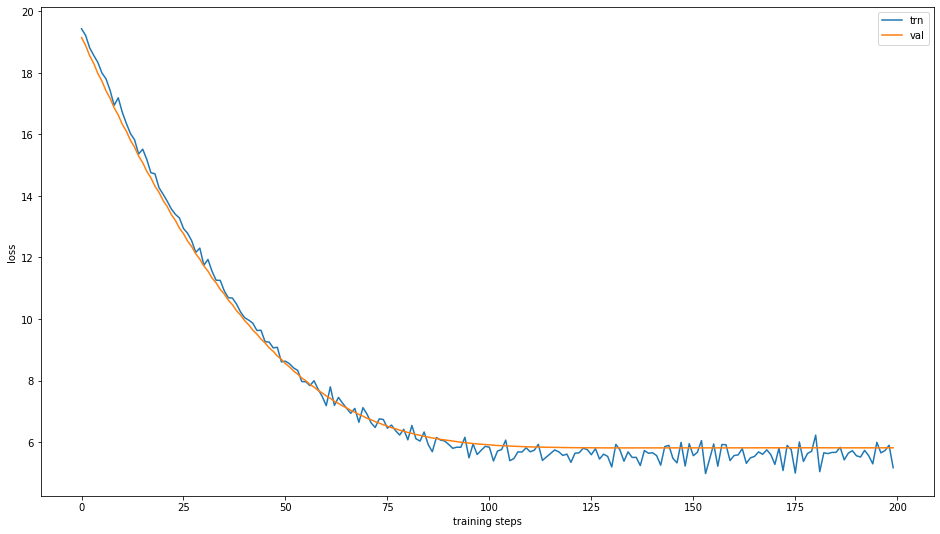

In [35]:
plt.figure(figsize=(16,9))
x_range = range(len(trn_loss_list))
plt.plot(x_range, trn_loss_list, label="trn")
plt.plot(x_range, val_loss_list, label="val")
plt.legend()
plt.xlabel("training steps")
plt.ylabel("loss")